# Full Method

Training and interpretation, with n_models simultaneously

#### import statements

In [1]:
import time
import datetime
import autoencodeSVJ.utils as utils
import autoencodeSVJ.evaluate as ev
import glob
import matplotlib.pyplot as plt
import matplotlib
import numpy as np
from collections import OrderedDict as odict
import pandas as pd
import glob
import os
import tensorflow as tf

%matplotlib inline
matplotlib.rcParams.update({'font.size': 16})
plt.rc('text', usetex=True)
plt.rc('font', family='serif')

Using TensorFlow backend.


#### Function definitions

In [2]:
def get_signal_auc_df(aucs, n_avg=1, do_max=False):
    lp = None
    if do_max:
        lp = aucs.max(axis=1).to_frame().reset_index().rename(columns={0:'auc'})
    else:
        lp = aucs.iloc[
            :,np.argsort(aucs.mean()).values[::-1][:n_avg]
        ].mean(axis=1).to_frame().reset_index().rename(columns={0: 'auc'})

    lp['mass'] = lp.mass_nu_ratio.apply(lambda x: x[0])
    lp['nu'] = lp.mass_nu_ratio.apply(lambda x: x[1])
    
    lp = lp.drop('mass_nu_ratio', axis=1).pivot('mass','nu',  'auc')

    return lp
                                                
def plot_signal_aucs_from_lp(lp, n_avg=1, do_max=False, title=None, fac=1.5, barlabel=None, cmap='viridis'):

    plt.figure(figsize=(1.1*fac*6.9,1.1*fac*6))

    plt.imshow(lp, cmap=cmap)
    if barlabel == None:
        barlabel='AUC value'
    cb = plt.colorbar()
    cb.set_label(label=barlabel, fontsize=18*fac)

    plt.xticks(np.arange(0,5,1), map(lambda x: '{:.2f}'.format(x), np.unique(lp.columns)))
    plt.yticks(np.arange(0,6,1), np.unique(lp.index))
    
    if title is not None:
        plt.title(title, fontsize=fac*25)
    elif do_max:
        plt.title('Best AUCs (for any autoencoder)', fontsize=fac*25)
    elif n_avg < 2:
        plt.title('Signal AUCs (best autoencoder)', fontsize=fac*25)
    else:
        plt.title('Average Signal AUCs (best {} models)'.format(n_avg), fontsize=fac*25)
    plt.ylabel(r'$M_{Z^\prime}$ (GeV)', fontsize=fac*20)
    plt.xlabel(r'$r_{inv}$', fontsize=fac*20)
    plt.xticks(fontsize=18*fac)
    plt.yticks(fontsize=18*fac)

    for mi,(mass,row) in enumerate(lp.iterrows()):
        for ni,(nu,auc) in enumerate(row.iteritems()):
            plt.text(ni, mi, '{:.3f}'.format(auc), ha="center", va="center", color="w", fontsize=18*fac)

    return plt.gca()
                                                
def plot_signal_aucs(aucs, n_avg=1, do_max=False, title=None, fac=1.5, cmap='viridis'):
    lp = get_signal_auc_df(aucs, n_avg, do_max)
    return lp, plot_signal_aucs_from_lp(lp, n_avg, do_max, title, fac, cmap=cmap)                                    

#### do training, or load set of trainings we already did

trained 50 models on 10/3/2020

training 150 more starting 10/4/2020

200 total!

In [108]:
TRAIN = False

lr = .00051
lr_factor = 0.5
es_patience = 12
target_dim = 8
batch_size = 32
norm_percentile = 25
epochs = 100
n_models = 200                  # number of models to train
model_acceptance_fraction = 10 # take top N best performing models

start_stamp = time.time()
res = None
if TRAIN:
    for i in range(n_models):
        mse = ev.ae_train(
            signal_path='data/all_signals/2000GeV_0.15/base_3/*.h5',
            qcd_path='data/background/base_3/*.h5',
            target_dim=target_dim,
            verbose=False,
            batch_size=batch_size,
            learning_rate=lr,
            norm_percentile=norm_percentile,
            lr_factor=lr_factor,
            es_patience=es_patience,
            epochs=epochs
        )
        print('model {} finished (mse = {:.4f})'.format(i, mse))
        print
    
    res = utils.summary()
    res = res[pd.DatetimeIndex(res.start_time) > datetime.datetime.fromtimestamp(start_stamp)]

else:
    res = utils.summary()
    res = res.sort_values('start_time').tail(n_models)
    
# take lowest 10% losses of all trainings
n_best = int(0.01*model_acceptance_fraction*n_models)
best_ = res.sort_values('total_loss').head(n_best)
best_name = str(best_.filename.values[0])

#### update & load AUC table

In [109]:
ev.update_all_signal_evals()

aucs = ev.load_auc_table()
bdts = pd.read_csv('autoencode/data/bdt_aucs.csv')
bdts = bdts[bdts.columns[1:]].set_index(bdts[bdts.columns[0]].rename('mass'))
bdts = bdts.T.set_index(bdts.T.index.rename('nu')).T
bdts.columns = map(float, bdts.columns)
bdts.index = map(float, bdts.index)

found 0 trainings total


#### Plot AUCs and compare to specialized BDTs

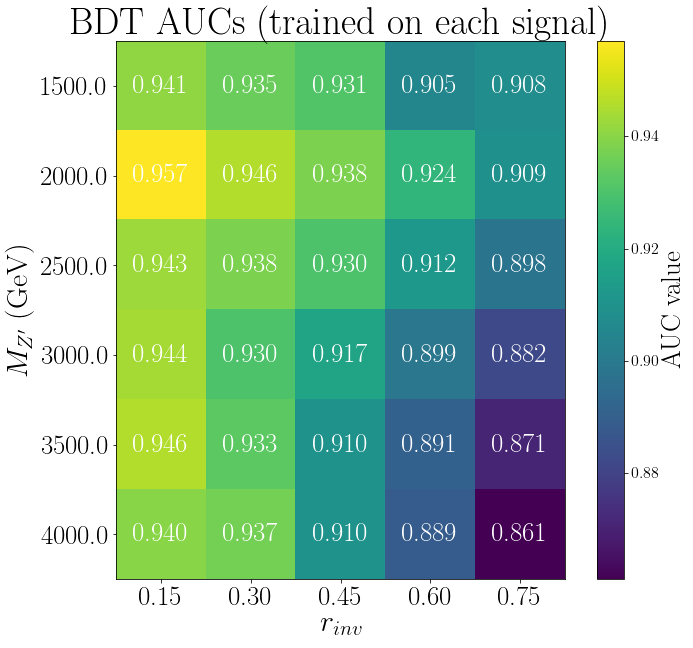

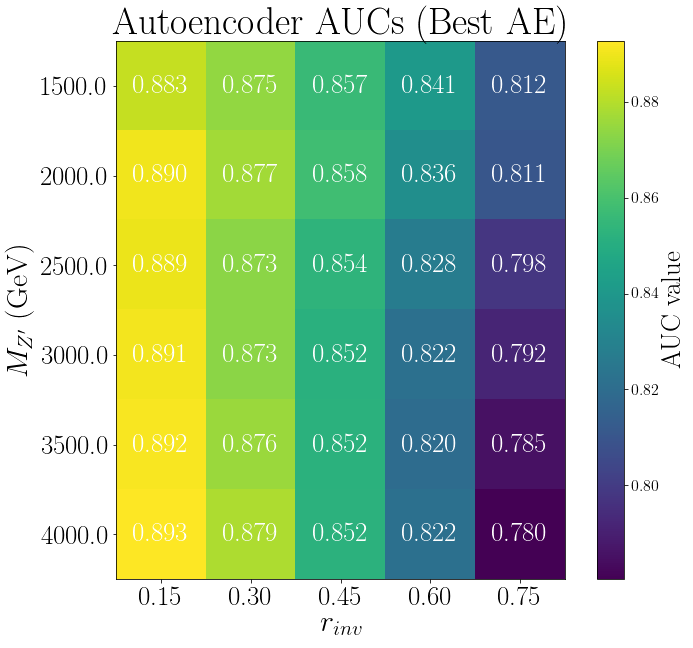

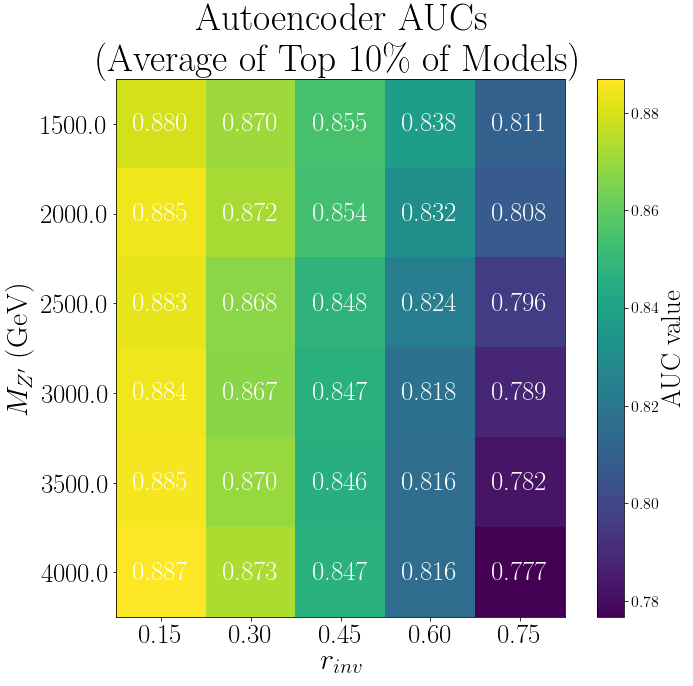

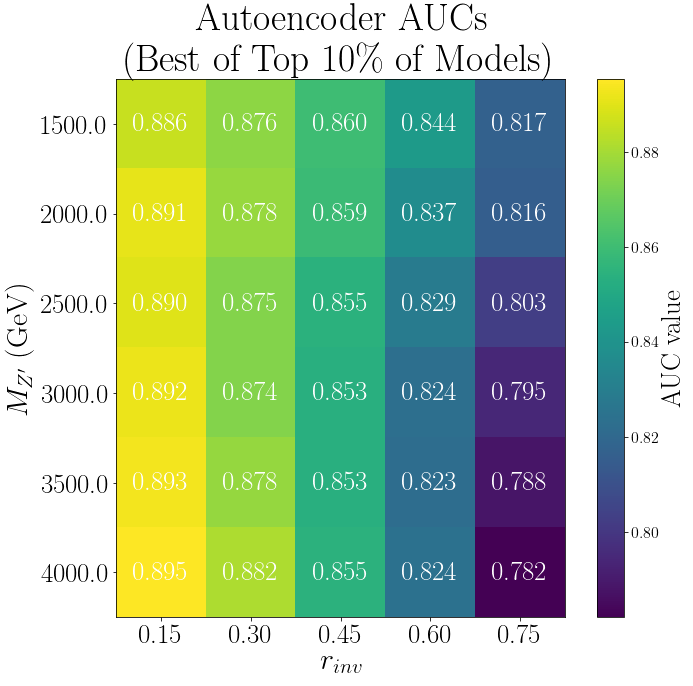

In [110]:
plot_signal_aucs_from_lp(bdts, title='BDT AUCs (trained on each signal)')
best,ax = plot_signal_aucs(aucs[best_name].to_frame(), title='Autoencoder AUCs (Best AE)')
best,ax = plot_signal_aucs(aucs[best_.filename], title='Autoencoder AUCs\n(Average of Top 10\% of Models)', n_avg=len(best_))
best,ax = plot_signal_aucs(aucs[best_.filename], do_max=1, title='Autoencoder AUCs\n(Best of Top 10\% of Models)', n_avg=len(best_))

In [111]:
res_aucs = aucs[res.filename]

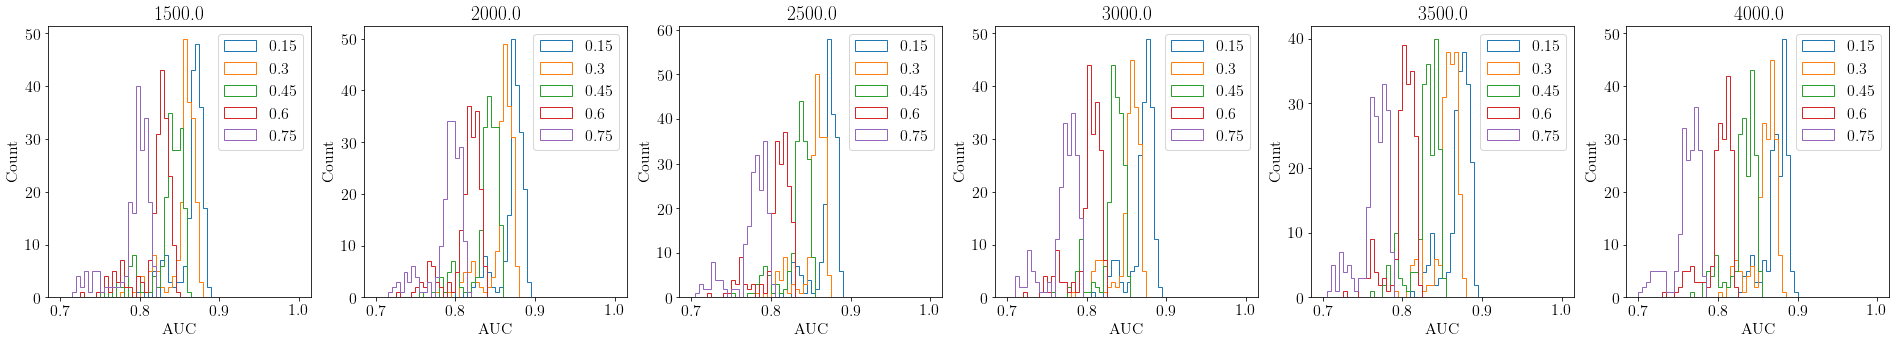

In [112]:
axis = 0
idx = np.asarray(map(list, res_aucs.index))
rows = list(np.unique(idx[:,axis]))
fig, axs = plt.subplots(1, len(rows), figsize=(5.5*len(rows), 5))

for cmb,row in res_aucs.iterrows():
    axs[rows.index(cmb[axis])].hist(row.values, histtype='step', bins=np.arange(.7, 1, .005), label=str(cmb[int(not axis)]))
for i,r in enumerate(rows):
    axs[rows.index(r)].set_xlabel('AUC')
    axs[rows.index(r)].set_title(r)
    axs[rows.index(r)].set_ylabel('Count')
    axs[rows.index(r)].legend()    

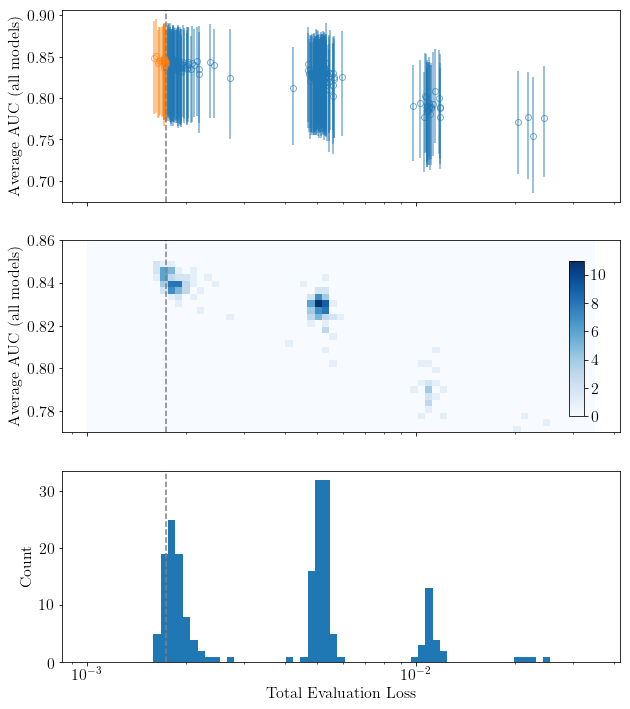

In [119]:
from matplotlib.ticker import LogFormatter

model_acceptance_fraction_ = 10

N = int(0.01*model_acceptance_fraction_*len(res))
keep = res.sort_values('total_loss').head(N)

fig, axes = plt.subplots(3, 1, figsize=(10,12), sharex=True)

x = res.set_index('filename').total_loss.sort_index()
y = res_aucs.mean()
yerr = np.asarray([(res_aucs.mean() - res_aucs.min()).values, (res_aucs.max()- res_aucs.mean()).values])
colors = np.asarray(list(map(lambda x: 'tab:blue' if not x else 'tab:orange', res_aucs.mean().index.isin(keep.filename))))

for color in np.unique(colors):
    idx = colors == color
    axes[0].errorbar(
        x[idx], y[idx], fmt='o', fillstyle='none', alpha=0.6, 
        yerr=yerr[:,idx], color=color
    )
# plt.xlim(0.0015, .0025)
wid = .18
cax = fig.add_axes([.83, 0.5 - wid/2, 0.02, wid])

axes[0].set_xscale('log')
axes[0].set_xticks([1e-3, 5e-3, 1e-2, 5e-2])
formatter = LogFormatter(labelOnlyBase=False, minor_thresholds=(2, 0.4))
axes[0].get_xaxis().set_minor_formatter(formatter)
axes[0].set_ylabel('Average AUC (all models)')


xbins, ybins = np.logspace(np.log10(.001), np.log10(0.035), 70), np.linspace(0.77, .86, 30)
cnts, xr, yr = np.histogram2d(x, y, bins=(xbins, ybins))
xm, ym = np.meshgrid(xr, yr)
im = axes[1].pcolormesh(xm, ym, cnts.T, cmap='Blues')
# axes[1].set_xlabel('Total Evaluation Loss')
axes[1].set_ylabel('Average AUC (all models)')
axes[1].set_xscale('log')
fig.colorbar(im, cax=cax, orientation='vertical')

axes[2].hist(res.total_loss, bins=xbins)
axes[2].set_xscale('log')
axes[2].set_ylabel('Count')
axes[2].set_xlabel('Total Evaluation Loss')

for ax in axes:
    ax.axvline(keep.total_loss.max(), color='tab:grey', ls='--')

# plt.colorbar()
plt.show()